# Data Prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_curve, average_precision_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D, Flatten, MaxPooling2D, Conv2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# function to filter for only desired categories
def get_categories(df, col, categories):
    return df[df[col].isin(categories)]

# function to change to binary label is cancer/not cancer
def cancer_labeling(dx):
    if dx == "akiec" or dx == 'mel' or dx == 'bcc':
        return '1-cancer'
    else:
        return '0-not cancer'
    
# function to change to binary label is melanoma/not melanoma
def melanoma_labeling(dx):
    if dx == 'mel':
        return '1-melanoma'
    else:
        return '0-not-melanoma'

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Using TensorFlow backend.


In [2]:
df = pd.read_csv('HAM10000_metadata.csv')

# process data
df = df.drop_duplicates(['lesion_id'])

# append jpg to image id
df['image_id'] = df['image_id'].transform(lambda x: x + '.jpg')

df.groupby('dx').count().join(
    df.groupby('dx').count()['lesion_id'].transform(lambda x: x/x.sum()*100).rename('%_images'))

# df.info()
df.head(100)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176.jpg,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837.jpg,bkl,histo,70.0,female,back
10,HAM_0001396,ISIC_0025276.jpg,bkl,histo,55.0,female,trunk
11,HAM_0004234,ISIC_0029396.jpg,bkl,histo,85.0,female,chest
13,HAM_0001949,ISIC_0025767.jpg,bkl,histo,70.0,male,trunk
15,HAM_0007207,ISIC_0031326.jpg,bkl,histo,65.0,male,back
16,HAM_0001601,ISIC_0025915.jpg,bkl,histo,75.0,male,upper extremity


In [3]:
# sample subset

# balance classes by dropping some nv 
nv = df[df['dx'] == 'nv'].sample(604, random_state=36) 

subset = df[df['dx'].isin(['akiec', 'bcc', 'bkl', 'mel'])]
subset = subset.append(nv)

# subset = subset.sample(300, random_state=42)

subset.groupby('dx').count().join(
    subset.groupby('dx').count()['lesion_id'].transform(lambda x: x/x.sum()*100).rename('%_images')
)

,lesion_id,image_id,dx_type,age,sex,localization,%_images
dx,,,,,,,
akiec,228,228,228,228,228,228,9.12
bcc,327,327,327,327,327,327,13.08
bkl,727,727,727,718,727,727,29.08
mel,614,614,614,613,614,614,24.56
nv,604,604,604,599,604,604,24.16


In [4]:
# split data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(
    subset['image_id'], 
    subset['dx'], 
    test_size=0.2, 
    random_state=42, 
    stratify=subset['dx']
)

y_train = y_train.transform(lambda x: cancer_labeling(x))
y_test = y_test.transform(lambda x: cancer_labeling(x))

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

pd.concat([train.groupby('dx').count()['image_id'].rename('train'),
           test.groupby('dx').count()['image_id'].rename('test')], axis=1
)


,train,test
dx,,
0-not cancer,1065,266
1-cancer,935,234


In [5]:
# Create image generator classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Import image data
img_dir = 'skin-cancer-mnist/'
img_resize = (128, 128)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    directory=img_dir, 
    x_col='image_id', 
    y_col='dx', 
    target_size=img_resize,
    class_mode='binary',
    batch_size=20,
)

test_generator = test_datagen.flow_from_dataframe(
    test, 
    directory=img_dir, 
    x_col='image_id', 
    y_col='dx', 
    target_size=img_resize,
    class_mode='binary',
    batch_size=20,
)

train_steps = train_generator.n//train_generator.batch_size
test_steps = test_generator.n//test_generator.batch_size

# print(train_generator.class_indices)
# print(test_generator.class_indices)
# print(val_generator.class_indices)


Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


# Model Building Functions

In [6]:
def build_model(base_model, optimizer):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    # Add dense layers so that the model can learn more complex functions and classify for better results.
    model.add(Dense(512,activation='relu')) #added
    model.add(Dense(256,activation='relu')) #added
    model.add(Dropout(0.5)) #added
#     model.add(Dense(128,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3)) #added
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.2)) #added


    # Final layer with sigmoid activation
    model.add(Dense(1,activation='sigmoid'))

    print(model.summary())

    # Train Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'],)
    
    return model


In [7]:
from keras.applications.densenet import DenseNet169

# Save model checkpoints
checkpointer = ModelCheckpoint('saved_model/resnet50.hdf5', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='acc', 
                              factor=0.5, 
                              patience=2, 
                              verbose=1, 
                              mode='max', 
                              min_lr=1e-15)

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

# Base model    
base_model = DenseNet169(weights='imagenet',include_top=False, input_shape=(128,128,3))

base_model.trainable = True
for layer in base_model.layers[:537]:
    layer.trainable = False
    
#     if unfrozen_layers == None:
#         base_model.trainable = False
#     else:
#         base_model.trainable = True
#         for layer in unfrozen_layers:
#             base_model.layers[layer].trainable = True
#             print(base_model.layers[layer].name, base_model.layers[layer].trainable)

base_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [114]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 zero_padding2d_5
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_6
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [25]:
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import classification_report

# epochs = 10

# csv_file = 'resnet_log.csv'
# log_writer = pd.DataFrame(columns=['loss', 'acc', 'lr', 'auc', 'avg_precision'])

model = build_model(base_model, Adam(lr=1e-4))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 4, 4, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               852480    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
__________

In [26]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch= train_steps,
    epochs=50,
    verbose=1,
    callbacks=[checkpointer, reduce_lr],
#     class_weight=class_weights
)

Epoch 1/50
100/100 [==============================] - 207s 2s/step - loss: 0.6817 - acc: 0.5600

Epoch 00001: saving model to saved_model/resnet50.hdf5
Epoch 2/50
100/100 [==============================] - 191s 2s/step - loss: 0.5014 - acc: 0.7655

Epoch 00002: saving model to saved_model/resnet50.hdf5
Epoch 3/50
100/100 [==============================] - 190s 2s/step - loss: 0.4405 - acc: 0.7920

Epoch 00003: saving model to saved_model/resnet50.hdf5
Epoch 4/50
100/100 [==============================] - 190s 2s/step - loss: 0.3779 - acc: 0.8345

Epoch 00004: saving model to saved_model/resnet50.hdf5
Epoch 5/50
100/100 [==============================] - 185s 2s/step - loss: 0.4022 - acc: 0.8135

Epoch 00005: saving model to saved_model/resnet50.hdf5
Epoch 6/50
100/100 [==============================] - 176s 2s/step - loss: 0.3632 - acc: 0.8495

Epoch 00006: saving model to saved_model/resnet50.hdf5
Epoch 7/50
100/100 [==============================] - 178s 2s/step - loss: 0.3423 - acc:

In [27]:
model.evaluate_generator(test_generator, 
                         steps=test_steps, 
                         verbose=1)

25/25 [==============================] - 55s 2s/step


[1.2546139574050903, 0.602000002861023]

In [28]:
prediction_scores = model.predict_generator(test_generator, 
                                            steps=test_steps, 
                                            verbose=1)

25/25 [==============================] - 56s 2s/step


              precision    recall  f1-score   support

           0       0.52      0.82      0.64       266
           1       0.43      0.15      0.23       234

   micro avg       0.51      0.51      0.51       500
   macro avg       0.48      0.49      0.43       500
weighted avg       0.48      0.51      0.45       500



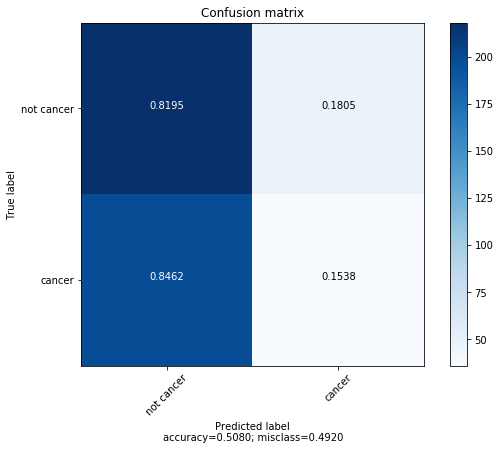

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_labels =['akiec', 'bcc', 'bkl', 'mel', 'nv']
y_true = test_generator.classes
# y_pred = np.argmax(prediction_scores, axis=1)
y_pred = [int(x >= 0.5) for x in prediction_scores]

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['not cancer', 'cancer'])

# y_pred
# prediction_scores




In [52]:
y_pred, y_true

(array([4, 1, 1, 4, 4, 1, 1, 4, 0, 4, 1, 4, 1, 1, 1, 4, 1, 4, 4, 4, 1, 4,
        1, 1, 1, 1, 1, 3, 4, 4, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 1, 1, 3,
        4, 1, 4, 1, 4, 1, 3, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1,
        4, 1, 4, 1, 1, 4, 4, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 4, 0, 1,
        1, 1, 1, 4, 0, 1, 0, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 1,
        1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 0, 0, 1, 1, 4, 4, 4, 4, 1, 1, 4, 1,
        4, 4, 4, 1, 4, 4, 4, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4,
        1, 3, 4, 1, 4, 1, 1, 4, 0, 4, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 4,
        1, 4, 1, 1, 4, 1, 1, 4, 4, 1, 4, 1, 4, 1, 4, 1, 3, 0, 4, 1, 1, 4,
        1, 1, 4, 1, 0, 4, 1, 4, 4, 1, 4, 0, 4, 4, 1, 1, 1, 1, 1, 1, 4, 4,
        1, 4, 1, 4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4,
        4, 4, 1, 4, 1, 0, 4, 4, 4, 1, 4, 4, 1, 0, 1, 1, 4, 4, 4, 4, 4, 4,
        4, 1, 1, 4, 1, 4, 4, 4, 0, 4, 0, 1, 4, 1, 4, 1, 1, 4, 4, 1, 1, 1,
        1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 

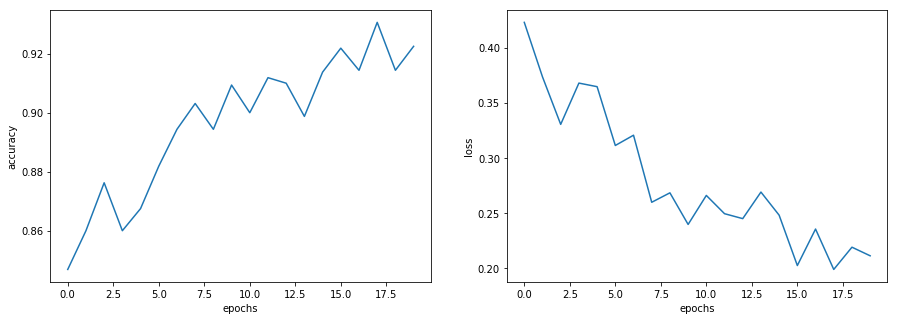

In [53]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()